# **Import Library**

In [1]:
import pandas as pd
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

# **Load Dataset**

In [2]:
df = pd.read_csv('Case Study - Transaction.csv', sep=';')
df.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


# **Data Cleansing**

In [3]:
# Mengecek tipe data
df.info()

# Mengecek Missing Value
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   TransactionID  5020 non-null   object
 1   CustomerID     5020 non-null   int64 
 2   Date           5020 non-null   object
 3   ProductID      5020 non-null   object
 4   Price          5020 non-null   int64 
 5   Qty            5020 non-null   int64 
 6   TotalAmount    5020 non-null   int64 
 7   StoreID        5020 non-null   int64 
dtypes: int64(5), object(3)
memory usage: 313.9+ KB


TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [4]:
# Mengubah kolom 'Date' menjadi tipe datetime
df['Date'] = pd.to_datetime(df['Date'])

# Melakukan grouping berdasarkan 'Date' dan menjumlahkan 'Qty'
df = df.groupby('Date')['Qty'].sum().reset_index()

# Mengubah kolom 'Date' menjadi indeks
df.set_index('Date', inplace=True)
print(df)

            Qty
Date           
2022-01-01   49
2022-01-02   50
2022-01-03   76
2022-01-04   98
2022-01-05   67
...         ...
2022-12-27   70
2022-12-28   68
2022-12-29   42
2022-12-30   44
2022-12-31   37

[365 rows x 1 columns]


<Axes: xlabel='Date'>

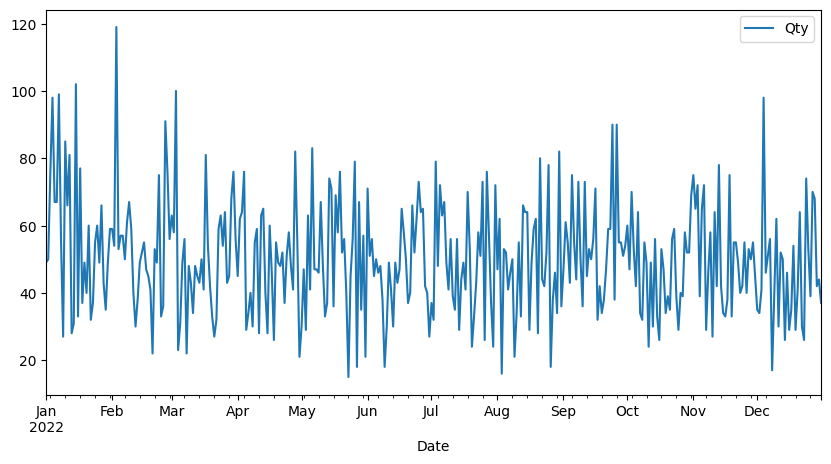

In [5]:
# Menampilkan plot dari Qty
df["Qty"].plot(legend=True,
               label="Qty",
               figsize=(10,5))

# **Check Stationarity**

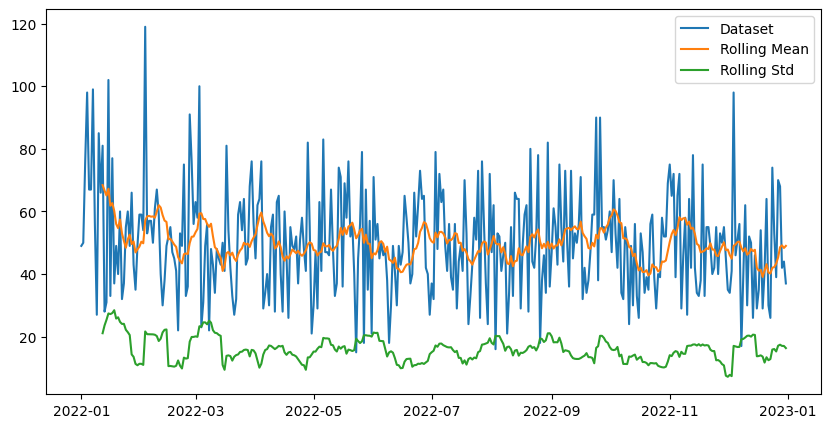

In [6]:
# Plot rolling statistics (rolling mean dan rolling standard deviation)
rolling_mean = df.rolling(window=12).mean()
rolling_std = df.rolling(window=12).std()

plt.figure(figsize=(10, 5))
plt.plot(df["Qty"], label='Dataset')
plt.plot(rolling_mean, label='Rolling Mean')
plt.plot(rolling_std, label='Rolling Std')
plt.legend()
plt.show()

# **Check Seasonality**

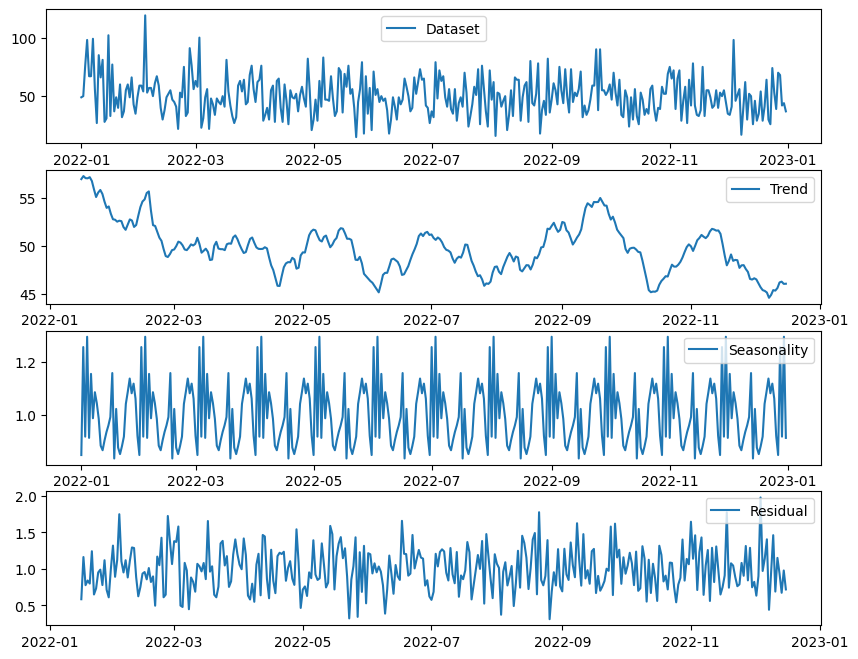

In [7]:
decomposition = seasonal_decompose(df["Qty"], period=30, model="multiplicative")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(10,8))
fig = plt.figure(1)

plt.subplot(411)
plt.plot(df["Qty"], label="Dataset")
plt.legend()
plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend()
plt.subplot(413)
plt.plot(seasonal, label="Seasonality")
plt.legend()
plt.subplot(414)
plt.plot(residual, label="Residual")
plt.legend()

# **Check ACF(p) and PACF(q)**

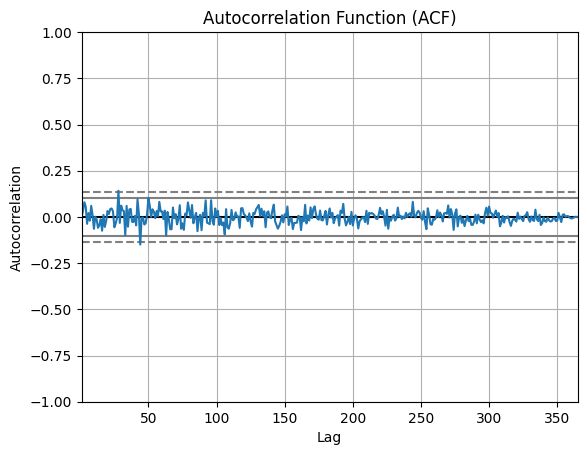

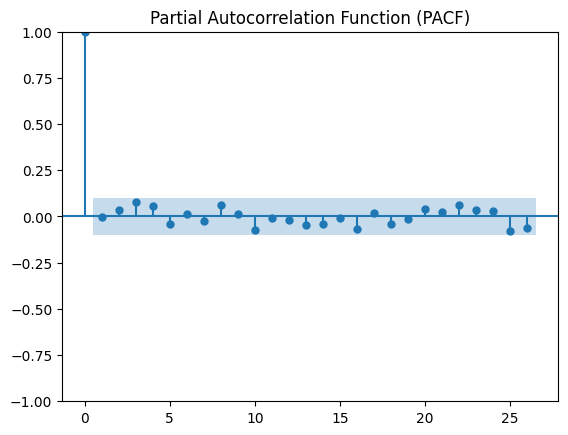

In [8]:
pd.plotting.autocorrelation_plot(df["Qty"])
plt.title('Autocorrelation Function (ACF)')
plt.show()

plot_pacf(df["Qty"])
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [9]:
# RESULT
d = 1 #seasonal
p = 5 #grafik ACF memotong 5 garis
q = 1 #1 titik terjauh pada PACF

# **Split Dataset**

In [10]:
train, test = df.iloc[:335], df.iloc[335:]
print(train.shape, test.shape)

(335, 1) (30, 1)


# **Build SARIMAX Model**

In [11]:
model = sm.tsa.statespace.SARIMAX(train["Qty"],
                                  order=(p,d,q),
                                  seasonal_order=(p,d,q,30))
model = model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                Qty   No. Observations:                  335
Model:             SARIMAX(5, 1, 1)x(5, 1, 1, 30)   Log Likelihood               -1311.517
Date:                            Wed, 26 Jul 2023   AIC                           2649.035
Time:                                    07:27:30   BIC                           2697.356
Sample:                                01-01-2022   HQIC                          2668.365
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0091      0.065     -0.140      0.888      -0.136       0.118
ar.L2         -0.0206      0.064   

# **Model Evaluation**

In [12]:
# Melakukan prediksi dengan testing data
start = len(train)
end = len(train)+len(test)-1
predictions = model.predict(start=start, end=end)
print(predictions)

2022-12-02    55.546705
2022-12-03    48.925845
2022-12-04    39.774810
2022-12-05    44.540952
2022-12-06    49.402763
2022-12-07    38.910991
2022-12-08    46.162662
2022-12-09    40.057311
2022-12-10    37.928694
2022-12-11    52.359023
2022-12-12    45.199835
2022-12-13    55.501276
2022-12-14    40.931464
2022-12-15    46.530706
2022-12-16    40.545030
2022-12-17    39.861520
2022-12-18    42.134185
2022-12-19    41.322744
2022-12-20    48.766481
2022-12-21    51.534158
2022-12-22    52.185755
2022-12-23    49.919937
2022-12-24    54.518633
2022-12-25    46.410852
2022-12-26    42.912932
2022-12-27    38.197466
2022-12-28    55.468595
2022-12-29    42.963010
2022-12-30    65.777202
2022-12-31    44.760264
Freq: D, Name: predicted_mean, dtype: float64


Text(0.5, 1.0, 'Comparison Actual Data with Predictions Data ')

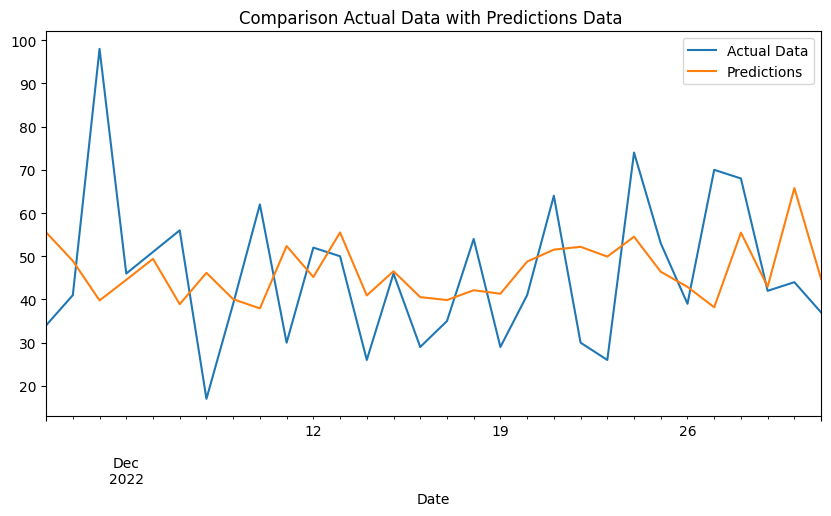

In [18]:
test["Qty"].plot(legend=True,
               label="Actual Data",
               figsize=(10,5))
predictions.plot(legend=True, label="Predictions")
plt.title('Comparison Actual Data with Predictions Data ')

In [14]:
# Check RMSE
from math import sqrt

rmse = sqrt(mean_squared_error(test["Qty"], predictions))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 18.544


# **Forecasting**

In [15]:
# Forecasting untuk 30 hari ke depan (1 bulan)
forecasting = model.predict(len(df), len(df)+30)
print(forecasting)

2023-01-01    56.098186
2023-01-02    49.546683
2023-01-03    45.055179
2023-01-04    43.692128
2023-01-05    48.016123
2023-01-06    42.033181
2023-01-07    44.946107
2023-01-08    37.256635
2023-01-09    40.647687
2023-01-10    48.043476
2023-01-11    44.107906
2023-01-12    53.294111
2023-01-13    41.294605
2023-01-14    49.787157
2023-01-15    39.550210
2023-01-16    35.546540
2023-01-17    41.218269
2023-01-18    38.742441
2023-01-19    50.008640
2023-01-20    50.975427
2023-01-21    53.648984
2023-01-22    45.616540
2023-01-23    59.438613
2023-01-24    48.081410
2023-01-25    41.508262
2023-01-26    34.955224
2023-01-27    55.409811
2023-01-28    42.621646
2023-01-29    65.269550
2023-01-30    37.982738
2023-01-31    54.615704
Freq: D, Name: predicted_mean, dtype: float64


<Axes: xlabel='Date'>

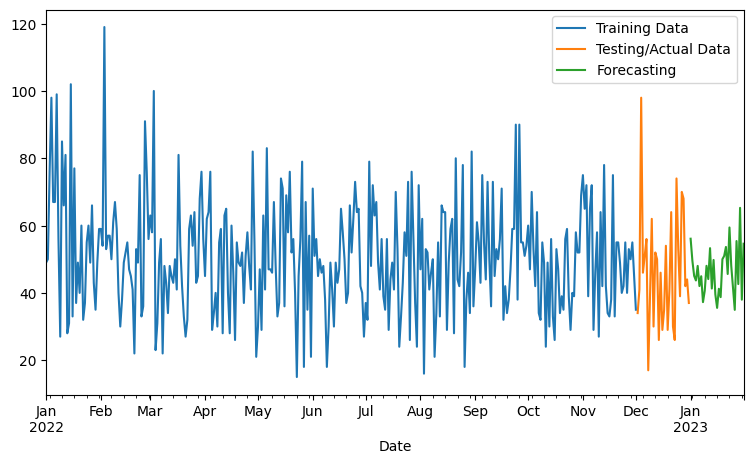

In [17]:
train["Qty"].plot(legend=True,
               label="Training Data",
               figsize=(9,5))
test["Qty"].plot(legend=True,
               label="Testing/Actual Data")
forecasting.plot(legend=True, label="Forecasting")